In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from net import *
from utils import *
from loss import *

In [2]:
img_root = "D:/nyc_taxi/data_min_max"
test_imgs = np.load(img_root+'/test.npy')
val_imgs = np.load(img_root+'/val.npy')

### Modeling

In [3]:
## parameters
img_root = "D:/nyc_taxi/data_min_max"
mask_root = "D:/nyc_taxi/data_min_max"
image_size = 64
chunk_size = 5
mape_loss = 0
test_imgs = np.load(img_root+'/test.npy')
test_masks_random = np.load(mask_root+'/test_random_mask.npy')
dataset_test = taxi_data(test_imgs, test_masks_random, image_size, chunk_size)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## load models
model = PConvUNet(chunk_size=chunk_size)
model.load_state_dict(torch.load(f'../../model_states/chunk_size_{chunk_size}/biased_{mape_loss}'))
model.eval()

## Parade

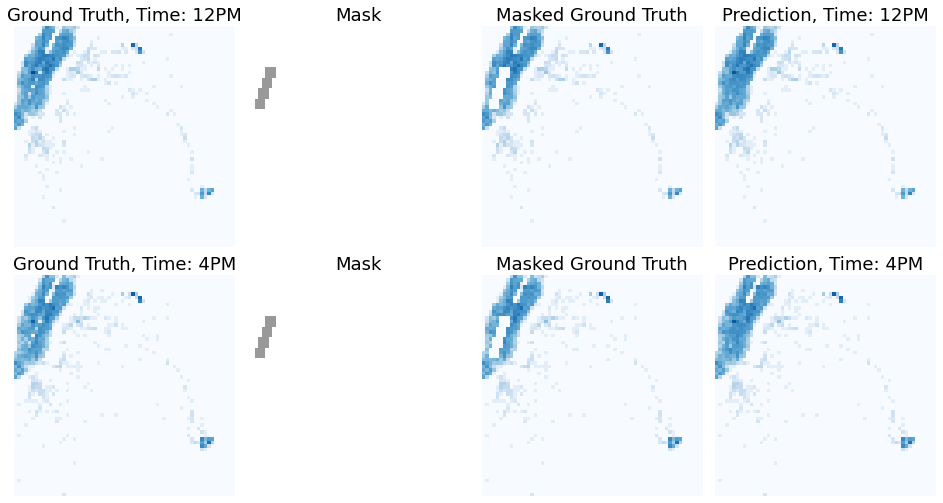

In [8]:
## param
color = 'Blues'
all_time_max = 1428
num = 2
times = ['12PM', '4PM']
## get test images
indices = [3516, 3520]
_, gt = zip(*[dataset_test[i] for i in indices])
mask, _ = zip(*[dataset_test[i] for i in indices])
mask = torch.stack(mask)
mask = torch.ones_like(mask)
mask[:,:,:,12, 5:8] = 0
mask[:,:,:,13, 5:8] = 0
mask[:,:,:,14, 5:8] = 0
mask[:,:,:,15, 4:7] = 0
mask[:,:,:,16, 4:7] = 0
mask[:,:,:,17, 4:7] = 0
mask[:,:,:,18, 3:6] = 0
mask[:,:,:,19, 3:6] = 0
mask[:,:,:,20, 3:6] = 0
mask[:,:,:,21, 2:5] = 0
mask[:,:,:,22, 2:5] = 0
mask[:,:,:,23, 2:5] = 0
gt = torch.stack(gt)
image = mask*gt

with torch.no_grad():
    output, _ = model(gt, mask)
output_comp = mask * gt + (1 - mask) * output

## scale back + log transformation
gt = torch.log(gt*all_time_max+1) 
image = torch.log(image*all_time_max+1)
output_comp = torch.log(output_comp*all_time_max+1)

## the last layer
gt = gt[:,:,-1,:,:]
mask = mask[:,:,-1,:,:]
image = image[:,:,-1,:,:]
output_comp = output_comp[:,:,-1,:,:]

## visualizations
VMAX=7
fig_size = 16
fig, axs = plt.subplots(num, 4, figsize=(fig_size,fig_size))
fontsize = 18
for i in range(num):
    axs[i,0].imshow(gt[i][0],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,0].set_title(f'Ground Truth, Time: {times[i]}', size=fontsize)
    axs[i,0].axis('off')
    axs[i,1].imshow(mask[i][0],cmap='gray', vmin=-1.5)
    axs[i,1].set_title('Mask', size=fontsize)
    axs[i,1].axis('off')
    axs[i,2].imshow(image[i][0],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,2].set_title('Masked Ground Truth', size=fontsize)
    axs[i,2].axis('off')
    axs[i,3].imshow(output_comp[i][0],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,3].set_title(f'Prediction, Time: {times[i]}', size=fontsize)
    axs[i,3].axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=-0.63)

### Zoom-in Manhattan 

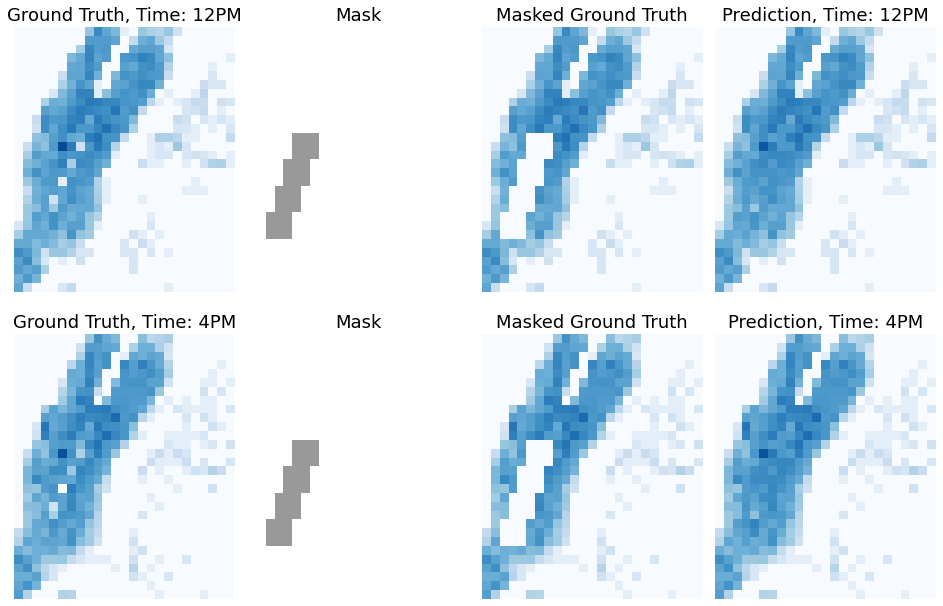

In [5]:
## visualizations
VMAX=7
fig_size = 16
fig, axs = plt.subplots(num, 4, figsize=(fig_size,fig_size))
fontsize = 18
long_boundary = 25
lat_boundary = 30
for i in range(num):
    axs[i,0].imshow(gt[i][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,0].set_title(f'Ground Truth, Time: {times[i]}', size=fontsize)
    axs[i,0].axis('off')
    axs[i,1].imshow(mask[i][0][:lat_boundary, :long_boundary],cmap='gray', vmin=-1.5)
    axs[i,1].set_title('Mask', size=fontsize)
    axs[i,1].axis('off')
    axs[i,2].imshow(image[i][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,2].set_title('Masked Ground Truth', size=fontsize)
    axs[i,2].axis('off')
    axs[i,3].imshow(output_comp[i][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,3].set_title(f'Prediction, Time: {times[i]}', size=fontsize)
    axs[i,3].axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=-0.5)

### Historical Values

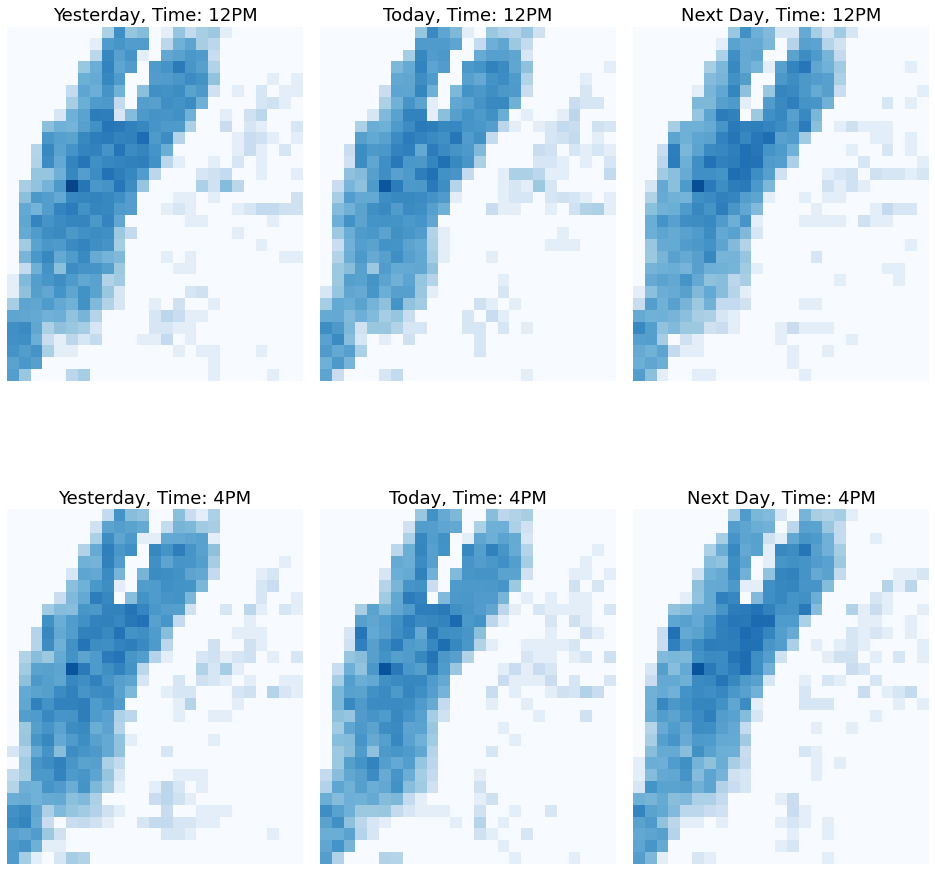

In [6]:
## visualizations
VMAX=7
fig_size = 16
fig, axs = plt.subplots(num, 3, figsize=(fig_size, fig_size))
fontsize = 18
long_boundary = 25
lat_boundary = 30
for i in range(num):
    neighbor_indices = [indices[i]-24, indices[i], indices[i]+24]
    _, gt = zip(*[dataset_test[i] for i in neighbor_indices])
    gt = torch.stack(gt)
    gt = gt[:,:,-1,:,:]
    gt = torch.log(gt*all_time_max+1)
    #gt[1] = output_comp_l1[i]
    
    ## visualizations
    axs[i,0].imshow(gt[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,0].set_title(f'Yesterday, Time: {times[i]}', size=fontsize)
    axs[i,0].axis('off')
    axs[i,1].imshow(output_comp[i][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,1].set_title(f'Today, Time: {times[i]}', size=fontsize)
    axs[i,1].axis('off')
    axs[i,2].imshow(gt[2][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,2].set_title(f'Next Day, Time: {times[i]}', size=fontsize)
    axs[i,2].axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=0.1)

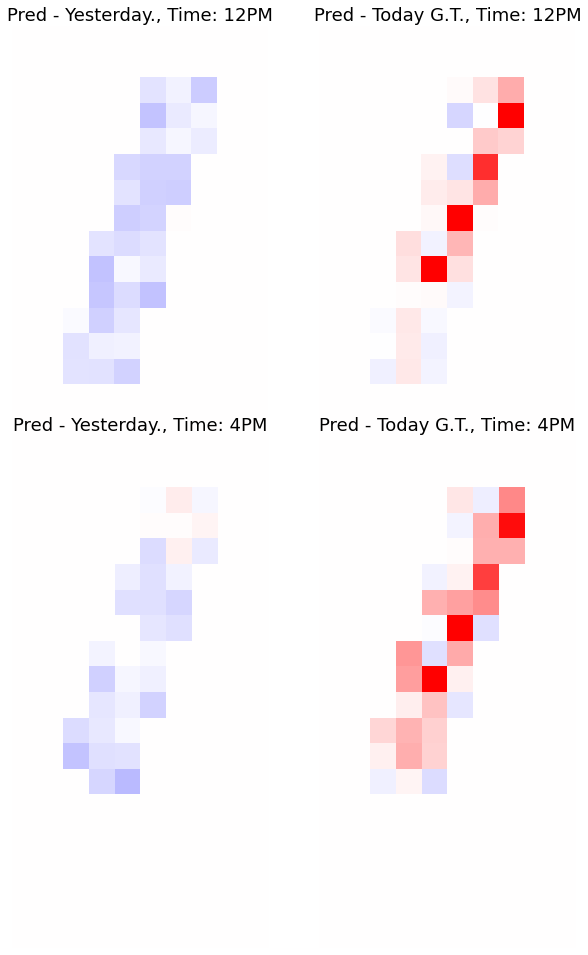

In [7]:
## visualizations
VMAX=2
VMIN=-2
fig_size = 16
fig, axs = plt.subplots(num, 2, figsize=(fig_size,fig_size))
fontsize = 18
long_boundary = 10
lat_upper = 10
lat_lower = 30
for i in range(num):
    neighbor_indices = [indices[i]-24, indices[i], indices[i]+24]
    _, gt = zip(*[dataset_test[i] for i in neighbor_indices])
    gt = torch.stack(gt)
    gt = gt[:,:,-1,:,:]
    gt = torch.log(gt*all_time_max+1)
    #gt[1] = output_comp_l1[i]
    
    ## visualizations
    axs[i,0].imshow(((1-mask[i][0])*output_comp[i][0])[lat_upper:lat_lower, :long_boundary]-\
                    ((1-mask[i][0])*gt[0][0])[lat_upper:lat_lower, :long_boundary],
                    vmin=VMIN, vmax=VMAX,cmap='bwr')
    axs[i,0].set_title(f'Pred - Yesterday., Time: {times[i]}', size=fontsize)
    axs[i,0].axis('off')
    axs[i,1].imshow(((1-mask[i][0])*output_comp[i][0])[lat_upper:lat_lower, :long_boundary]-\
                    ((1-mask[i][0])*gt[1][0])[lat_upper:lat_lower, :long_boundary],
                    vmin=VMIN, vmax=VMAX,cmap='bwr')
    axs[i,1].set_title(f'Pred - Today G.T., Time: {times[i]}', size=fontsize)
    axs[i,1].axis('off')
    #axs[i,2].imshow(((1-mask[i][0])*output_comp_l1[i][0])[lat_upper:lat_lower, :long_boundary]-\
    #                ((1-mask[i][0])*gt[2][0])[lat_upper:lat_lower, :long_boundary],
    #                vmin=VMIN, vmax=VMAX,cmap='bwr')
    #axs[i,2].set_title(f'Pred - Next Day., Time: {times[i]}', size=fontsize)
    #axs[i,2].axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=-0.5, 
                    hspace=-0.2)